# Machine Learning Pipeline - Feature Selection

In the following notebooks, we will go through the implementation of each of the steps in the Machine Learning Pipeline.

We will discuss:

1. Data Analysis
2. Feature Engineering
3. **Feature Selection**
4. Model Training
5. Obtaining Predictions / Scoring

Our selection procedure will be focused solely on non-parametric statistical methods because they are model-agnostic. We avoid model-specific methods because:

1. They can be very computationally expensive. This project is being run on a local machine and not a distrubuted system.
2. Model-specific methods would require us to use the same model in training as we did in feature selection for consistency. This is impractical as we still have to run our data through a range of options during training before deciding on our most optimal model.

In [1]:
# to handle datasets
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [2]:
# to run statistical tests
from scipy.stats import kruskal, mannwhitneyu, spearmanr, chi2_contingency, ttest_ind
from sklearn.feature_selection import f_classif

In [3]:
# to visualise all the columns in the dataframe
pd.pandas.set_option('display.max_columns',None)

In [4]:
# load the train and test sets with the engineered variables
X_train = pd.read_csv('xtrain_unscaled.csv')
X_test = pd.read_csv('xtest_unscaled.csv')

In [5]:
X_train.head()

,Age,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,Oldpeak,ST_Slope,Sex_M,ExerciseAngina_Y,FastingBS_1
0,70,4,140.0,242.881864,1,157,2.0,3,1,1,1
1,46,4,115.0,242.881864,1,113,1.5,3,1,1,0
2,65,2,160.0,360.000000,2,151,0.8,1,0,0,0
3,66,4,140.0,139.000000,1,94,1.0,3,1,1,0
4,59,4,140.0,242.881864,3,117,1.0,3,1,1,0


In [6]:
# load the target
y_train = pd.read_csv('ytrain.csv')
y_test = pd.read_csv('ytest.csv')

In [7]:
y_train.head()

,HeartDisease
0,1
1,1
2,0
3,1
4,1


# Feature Selection

Let's go ahead and select a subset of the most predictive features.

## Drop constant features
Constant features show the same value for all observations in the dataset and provide no information value for a machine learning model. As a sanity check, we will check all our variables for constant features and remove them.

In [8]:
constant_features = [feat for feat in X_train.columns if X_train[feat].nunique() == 1]
constant_features

[]

We have no variables with constant values in the dataset.

## Drop quasi-constant features

Quasi-constant features also show the same value but only for the great majority of the observations. Like constant features, they provide little, if any, information value for any model to work with.

As another sanity check, we will also check all our columns for quasi-consyant features and remove them.

In [9]:
# creat an empty list
quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:
    
    # find the predominant value, i.e. the value shared
    # by most observations
    predominant = (X_train[feature].value_counts() / float(
        len(X_train))).sort_values(ascending=False).values[0]
    
    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

In [10]:
len(quasi_constant_feat)

0

Our dataset does not have any variables with quasi-constant values.

## Statistical Tests

We will now evaluate our variables individually to select variables with a strong predictive association with our target.

### Continuous Variables
Recall that our distributions were Gaussian-like in our data analysis notebook. This would thus inform our adoption of parametric methods in determining variable association. To be sure about our results, we can also run nonparametric tests. Where the results differ, we will accept the nonparametric results.

In [11]:
cont_vars = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']

Let's test the hypothesis and grab the p-values of the continuous variables with the Student t-test and the Mann-Whitney U test:

In [12]:
train = pd.concat([X_train,y_train],axis=1)

# empty dictionaries to hold the p values from the two tests
p_ls_ttest = {}
p_ls_mann = {}

# iterate over the continuous variables
for var in cont_vars:
    
    # separate the two samples from the target for each variable
    data_1 = train[train['HeartDisease']==0][var]
    data_2 = train[train['HeartDisease']==1][var]
    
    # student t-test
    stat, p_ttest = ttest_ind(data_1,data_2)
    p_ls_ttest[var] = p_ttest
    
    # mann-whitney u test
    stat, p_mann = mannwhitneyu(data_1,data_2)
    p_ls_mann[var] = p_mann

<AxesSubplot:>

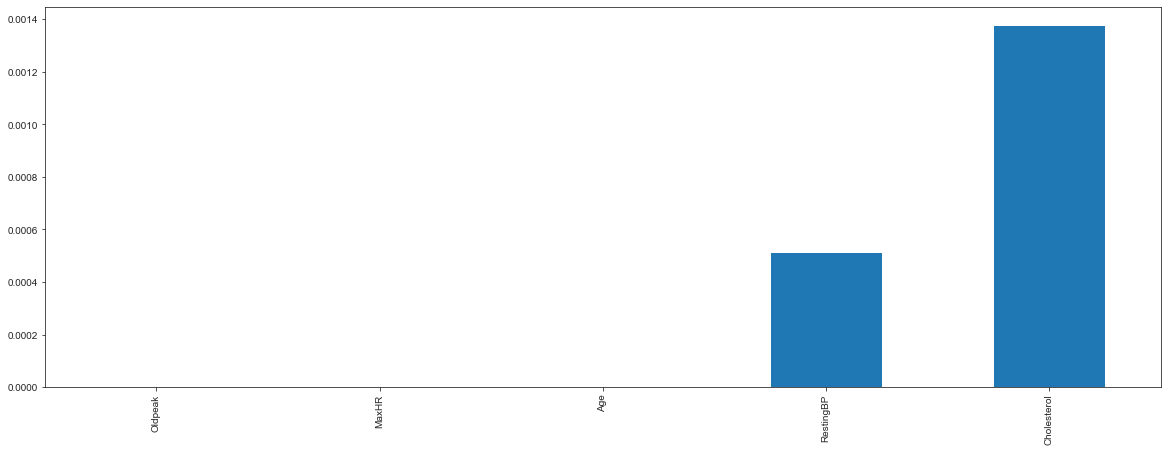

In [13]:
# plot out the p values for the t-test
p_ls_mann = pd.Series(p_ls_mann)
p_ls_mann.sort_values(ascending=True).plot.bar(figsize=(20,7))

<AxesSubplot:>

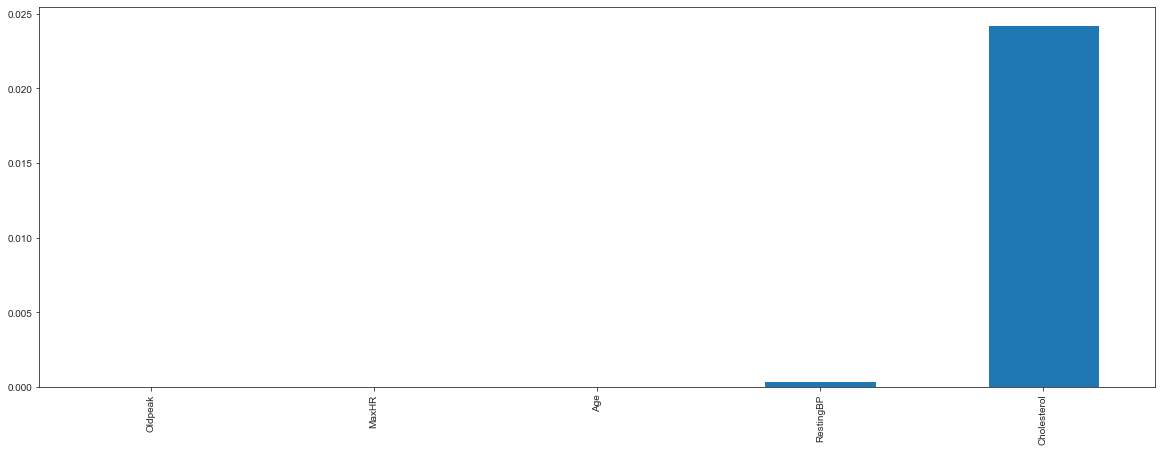

In [14]:
# plot out the p values for the mann-whitney u test
p_ls_ttest = pd.Series(p_ls_ttest)
p_ls_ttest.sort_values(ascending=True).plot.bar(figsize=(20,7))

Both tests confirm that all our continuous variables are associated with the target at the 5% significance level. The p-value rankings for both variables are also similiar even though their values are different. The degree of association would still have to be determined by a computation of the effect sizes.

Let's now go ahead to compute the effect sizes:

In [15]:
# gaussian-distributed effect size

def cohen_d(data1, data2):
    
    # calculate the size of samples
    n1, n2 = len(data_1), len(data_2)
    
    # calculate the variance of the samples
    s1, s2 = np.var(data_1, ddof=1), np.var(data_2, ddof=1)
    
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 -2))
    
    # calculate the means of the samples
    u1, u2 = np.mean(data_1), np.mean(data_2)
    
    # calculate the effect size
    return (u1 - u2) / s

In [16]:
effect_sizes = {}

for var in cont_vars:
    
    data_1 = train[train['HeartDisease']==0][var]
    data_2 = train[train['HeartDisease']==1][var] 
    
    d = cohen_d(data_1, data_2)
    effect_sizes[var] = abs(d)

Text(0.5, 1.0, 'Parameteric effect sizes of categorical variables')

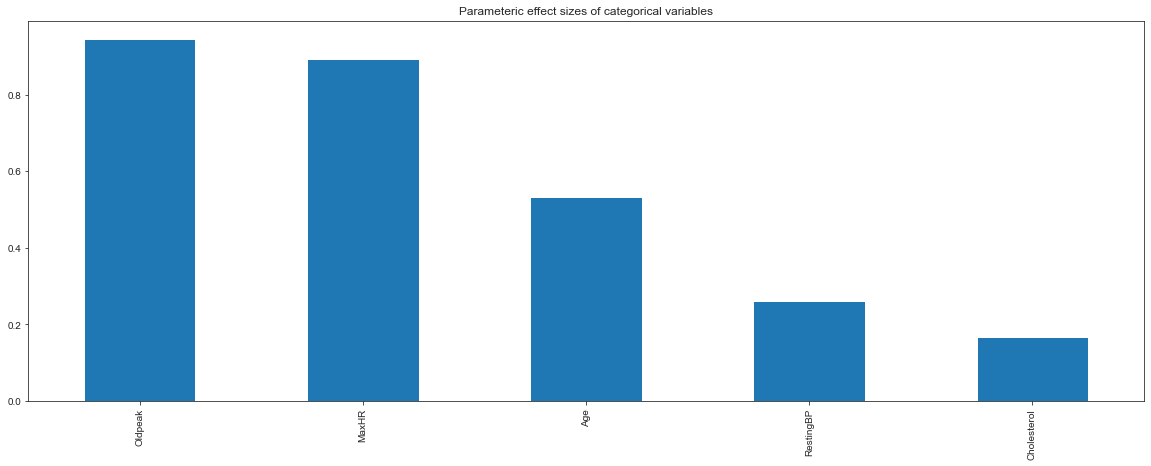

In [17]:
# plot out the effects
effect_sizes = pd.Series(effect_sizes)
effect_sizes.sort_values(ascending=False).plot.bar(figsize=(20,7))
plt.title('Parameteric effect sizes of categorical variables')

In [18]:
# print out the effect
effect_sizes.sort_values(ascending=False)

Oldpeak        0.946102
MaxHR          0.892613
Age            0.531759
RestingBP      0.262314
Cholesterol    0.167377
dtype: float64

In [19]:
# distribution-free effect size

def mw_effect_size(df, var):
    
    # separate the two samples
    data_1 = train[train['HeartDisease']==0][var]
    data_2 = train[train['HeartDisease']==1][var] 
    
    # grab the p value and the test statistic
    U1, p = mannwhitneyu(data_1, data_2)
    nx, ny = len(data_1), len(data_2)
    
    # calculate the z score
    U2 = (nx*ny) - U1
    U = min(U1, U2)
    N = nx + ny
    z = (U - nx*ny/2 + 0.5) / np.sqrt(nx*ny * (N + 1)/ 12)
    
    # compute the effect size
    r = z / np.sqrt(N)
    return r

In [20]:
# empty dictionary to store the sizes
sizes = {}

# iterate over each variable
for var in cont_vars:
    
    # store the size and variable name in the dictionary
    size = mw_effect_size(train, var)
    sizes[var] = abs(size)

Text(0.5, 1.0, 'Nonparametric effect sizes of continuous variables')

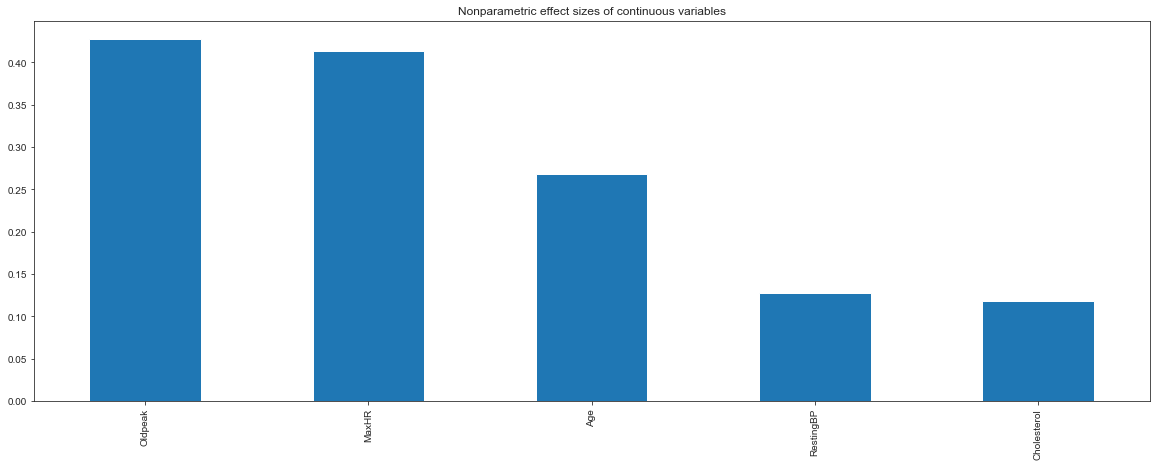

In [21]:
# plot out the sizes in ascending order
sizes = pd.Series(sizes)
sizes.sort_values(ascending=False).plot.bar(figsize=(20,7))
plt.title('Nonparametric effect sizes of continuous variables')

Notice the variables with the lowest p-values have the largest size effects.

### Categorical Variables

Let us now assess the p-values and the effect sizes of the categorical variables.

In [22]:
# list out the categorical variables
cat_vars = ['Sex_M', 'ExerciseAngina_Y', 'FastingBS_1', 'ChestPainType', 'RestingECG', 'ST_Slope']

In [23]:
p_ls = []
chi_ls = []

for feature in cat_vars:
    
    # create contingency table
    c = pd.crosstab(train['HeartDisease'], train[feature])
    
    # chi_test
    chi = chi2_contingency(c)[0]
    p_value = chi2_contingency(c)[1]
    
    chi_ls.append(chi)
    p_ls.append(p_value)

Text(0.5, 1.0, 'Feature importance based on chi-square test')

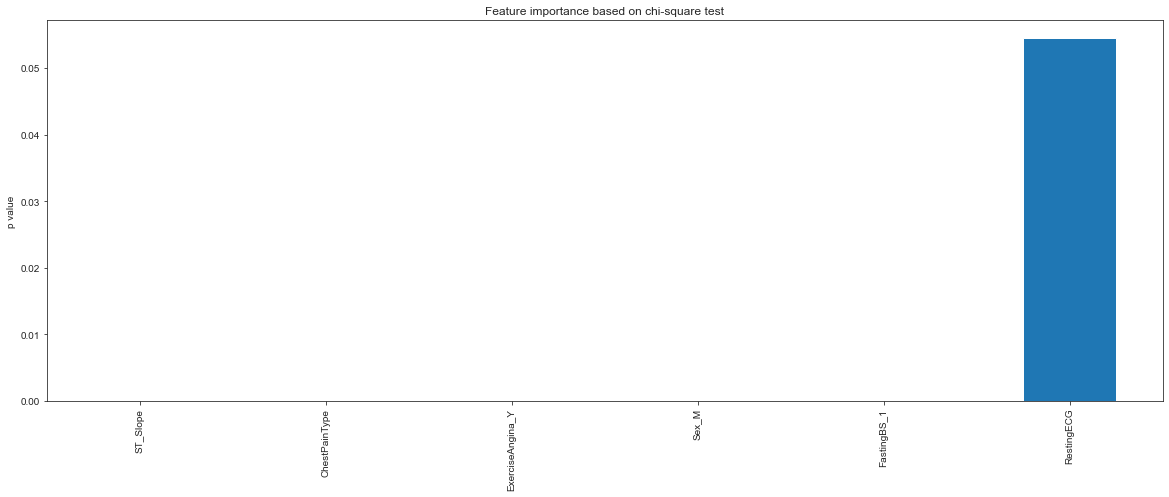

In [24]:
pd.Series(p_ls, index=cat_vars).sort_values(ascending=True).plot.bar(rot=90,figsize=(20,7))
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')

In [25]:
pd.Series(p_ls, index=cat_vars).sort_values(ascending=True)

ST_Slope            3.438604e-68
ChestPainType       1.531057e-46
ExerciseAngina_Y    4.356672e-41
Sex_M               4.371673e-15
FastingBS_1         4.098078e-14
RestingECG          5.443787e-02
dtype: float64

Text(0.5, 1.0, 'Feature importance based on chi-square test')

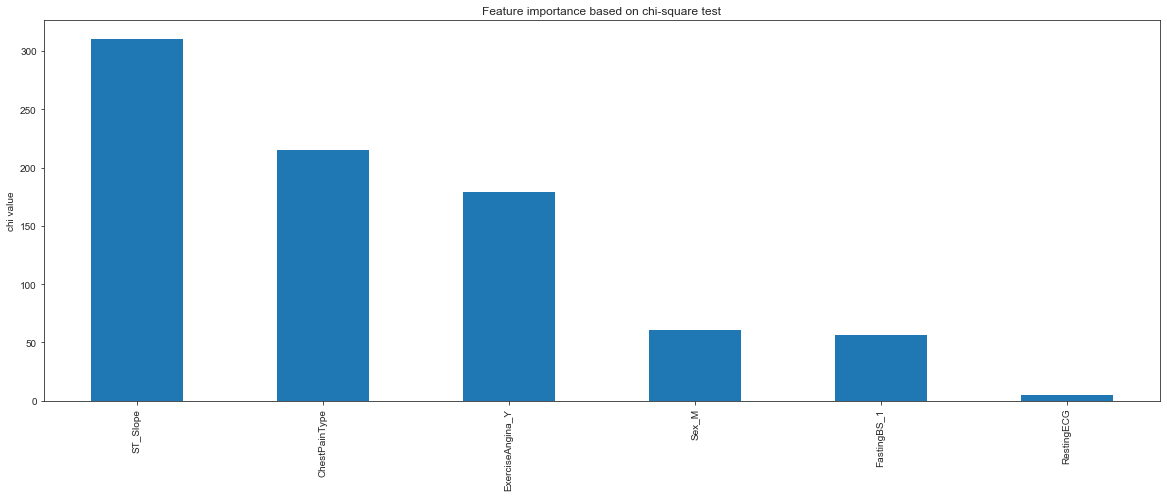

In [26]:
pd.Series(chi_ls, index=cat_vars).sort_values(ascending=False).plot.bar(rot=90,figsize=(20,7))
plt.ylabel('chi value')
plt.title('Feature importance based on chi-square test')

In [27]:
pd.Series(chi_ls, index=cat_vars).sort_values(ascending=False)

ST_Slope            310.681442
ChestPainType       215.918429
ExerciseAngina_Y    180.211896
Sex_M                61.524954
FastingBS_1          57.120993
RestingECG            5.821391
dtype: float64

We can now store all our selected features in a list. For this project, they just happen to be all the features from the original dataset excluding only RestingECG.

In [28]:
selected_features = list(X_train.drop('RestingECG',axis=1).columns)
selected_features

['Age',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'MaxHR',
 'Oldpeak',
 'ST_Slope',
 'Sex_M',
 'ExerciseAngina_Y',
 'FastingBS_1']

In [29]:
# save our selected features for the next notebook
pd.Series(selected_features).to_csv('selected_features.csv', index=False)